   # TRF Tutorial

   In this notebook we show how to import word onset as a word-level feature and compute TRF from them.

   ## Import EEG

In [1]:
import os
from scipy.io import loadmat
from pyeeg.io import eeglab2mne

subj_id = 3 # id of participant (3 is subject P04)
story_id = 1 # id of stories (1 is AUNP02)

In [2]:
eeg_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/Processed/Fs-125/interp_bad/BP-0.3-65/Blink_pruned/'
list_subjects = os.listdir(eeg_path)
eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]

event_id = dict(boundary=-1, story_onset=1)
raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
raw.pick_types(eeg=True)

# Filtering the EEG
raw = raw.filter(1, 15, n_jobs=2)

1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


   ## Import Word-level features
   
   We will load _surprisal_ feature and fit a TRF model on both _word onsets_ and _surprisal_ word features.

In [3]:
# Import all paths
from pyeeg.io import WordLevelFeatures
env_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/story_parts/alignement_data/'
wordfreq_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/story_parts/word_frequencies/'
surprisal_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/story_parts/surprisal/'
list_wordfreq_files = [item for item in os.listdir(wordfreq_path) if item.endswith('timed.csv')]
list_surprisal_files = [item for item in os.listdir(surprisal_path) if item.endswith('3.txt')]
list_stories = [item.strip('_word_freq_timed.csv') for item in list_wordfreq_files]
list_env_files = [os.path.join(env_path, s, s + '_125Hz.Env') for s in list_stories]

onset_path = '/home/hw2512/Workspace/EEG_work/all_katerina_onsets.mat'
onsets = loadmat(onset_path)['onsets']

# Loading word onset and duration for AUNP02:
wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
duration_path = os.path.join(env_path, list_env_files[story_id])
surp_path = os.path.join(surprisal_path, list_surprisal_files[1])

In [4]:
# Create word-level feature object:
wf = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path, path_surprisal=surp_path)

# Creating feature matrix
x = wf.align_word_features(srate=raw.info['sfreq'], features=('surprisal',))

# Getting EEG data
y = raw.get_data()

# Croping data with indices that match current story for this participant
indices = wf.samples_from_onset(onsets[subj_id, story_id], srate=raw.info['sfreq'])
y = y[:, indices].T

INFO:pyeeg.io:Adding feature surprisal


   ## Run TRF modelling
 The TRFEstimator class allows to use any arbitrary set of lags. The lagged time series design matrix
 will be generated when fitting the class instance to aligned EEG and feature data.

In [5]:
from pyeeg.models import TRFEstimator

# TRF instance
reg_param = 0. # Ridge parameter
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)

# Fit our model
trf.fit(x, y, feat_names=["Word Onsets", "Surprisal"])

INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


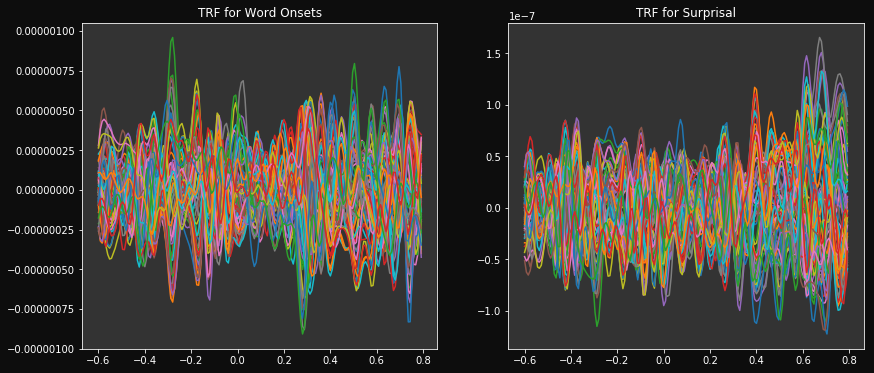

In [7]:
# Plot model:
trf.plot_single_feature(feat_id=[0,1], figsize=(14,6))